In [3]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table

import pickle

from pyslime import slime
from pyslime import utils as pu
from pyslime.pipeline import pipelineUtils as ppu


bpDensityFile = '/Users/mwilde/Dropbox/slime-mold/data/final_data/BP_0214_densities_1024_0.bin'
bpslimedir = '/Volumes/GoogleDrive-101511024793685627081/My Drive/SlimeMold/2021-10-12/BP_z=0_float32'
bpdatafile = 'trace_BP_z=0_float32.bin'
out_pickle_file = '../data/mapping_BP_z0p0_1sigma.pick'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the BP simulation data and the BP slime data. DO NOT STANDARDIZE

In [4]:
logrhom = ppu.get_sim_data(bpDensityFile)
bpslime = pu.get_slime(bpslimedir,
                         datafile=bpdatafile,
                         dtype=np.float32,
                         standardize=False)

/Users/mwilde/python/pyslime/pyslime/utils.py:331: RuntimeWarning: divide by zero encountered in log10
  slimeobj.data = np.log10(slimeobj.data)


((5, 720, 720), (5, 1024, 1024))

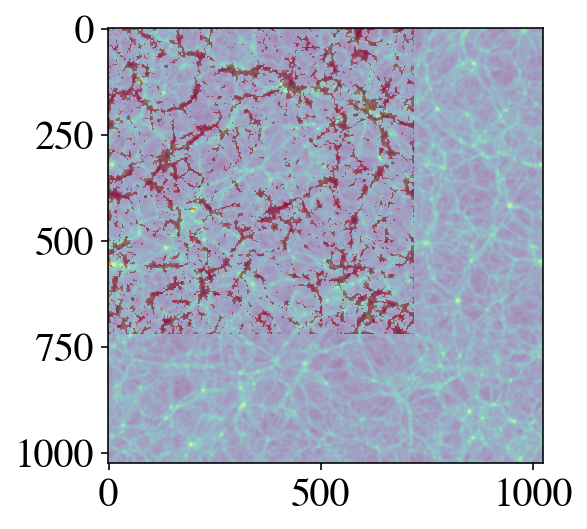

In [66]:
plt.imshow(np.sum(bpslime.data[0:5, :,:], axis=0), cmap='Reds', alpha=1)
plt.imshow(np.sum(logrhom[0:5, :,:], axis=0), alpha=0.5)

bpslime.data[0:5, :,:].shape, logrhom[0:5, :,:].shape

## Sample from both data sets randomly for sanity check

<Figure size 720x504 with 0 Axes>

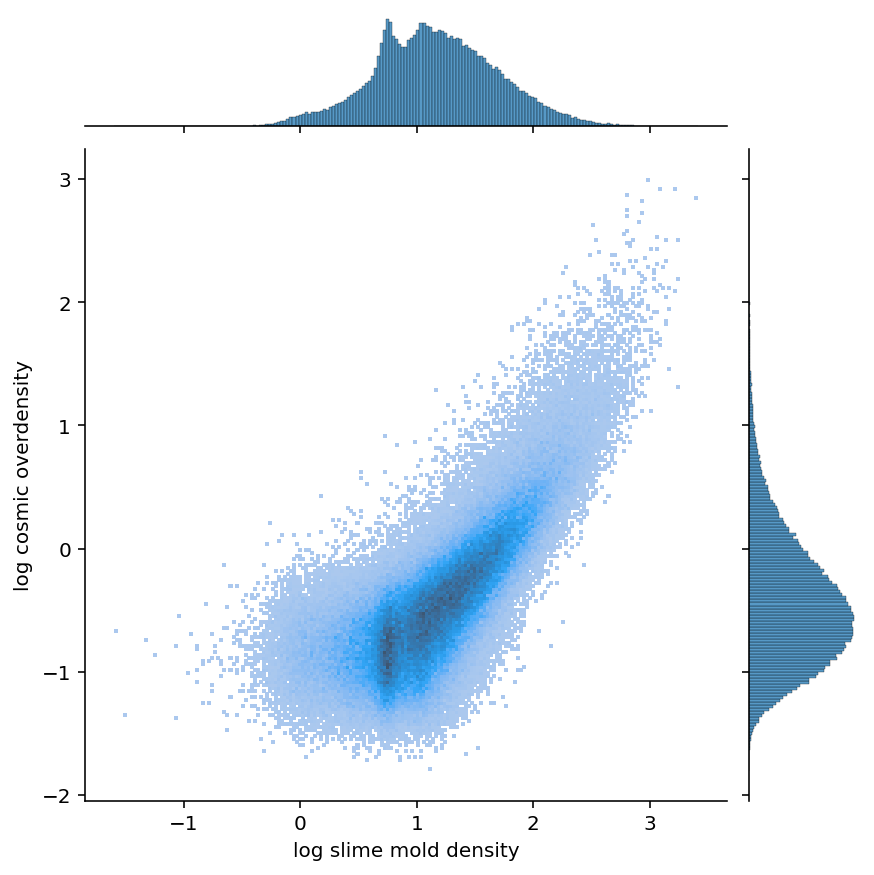

In [5]:
ridxs1 = np.random.randint(0, 1023, size=200000)
ridxs2 = np.random.randint(0, 1023, size=200000)
ridxs3 = np.random.randint(0, 1023, size=200000)

randvals = logrhom[ridxs1,ridxs2,ridxs3]
xdist, ydist, zdist = ppu.bprho_idx_to_dist(ridxs1, ridxs2, ridxs3)

sm_dense_list = []

smdensvals = np.zeros(len(xdist))
i = 0
for i,xd in enumerate(xdist):
    smidx_x, smidx_y, smidx_z = bpslime.cartesian_to_idx(xd, ydist[i], zdist[i])
    try:
        smdensvals[i] = bpslime.data[smidx_x, smidx_y, smidx_z]
    except:
        print(xdist[i], ydist[i], zdist[i])
        print(smidx_x, smidx_y, smidx_z)
        i+=1
plt.figure(figsize=(10,7))


notinf = ~np.isinf(randvals) & ~np.isinf(smdensvals)
import seaborn as sns
g = sns.jointplot(y=randvals[notinf], x=smdensvals[notinf], kind="hist")
g.set_axis_labels(xlabel='log slime mold density', ylabel='log cosmic overdensity');

In [6]:
maxdens = bpslime.data.max( )
maxdens

4.0386014

## Sample the densites from the slime fit to the simulation and get the corresponding density from the simulation.

In [7]:
mindens = bpslime.data[~np.isinf(bpslime.data)].min() - 0.1
maxdens = bpslime.data.max( )+ 0.2 

smrhobins = np.arange(mindens,maxdens,0.1)

smrhobins = np.arange(mindens,maxdens,0.1)
bpdistribs_sm, smdistribs_sm = ppu.sample_bins(bpslime, logrhom, 
                                               smrhobins, size=20000)
                                               

-1.6991131067276002 0
-1.5991131067276 407
-1.4991131067276 556
-1.3991131067276 887
-1.2991131067275998 1205
-1.1991131067275997 1848
-1.0991131067275997 2966
-0.9991131067275996 4679
-0.8991131067275995 8170
-0.7991131067275994 14463
-0.6991131067275993 27618
-0.5991131067275992 55958
-0.4991131067275991 121278
-0.39911310672759903 270915
-0.29911310672759894 607344
-0.19911310672759885 1269027
-0.09911310672759877 2231702
0.0008868932724013234 3089108
0.10088689327240141 3647706
0.2008868932724015 4573710
0.3008868932724016 6013644
0.4008868932724017 7696642
0.5008868932724018 10084866
0.6008868932724019 15552143
0.700886893272402 24758989
0.800886893272402 20735063
0.9008868932724021 21152498
1.0008868932724022 24825365
1.1008868932724023 23223680
1.2008868932724024 22778952
1.3008868932724025 21210881
1.4008868932724026 19361333
1.5008868932724027 17212235
1.6008868932724027 14835255
1.7008868932724028 12396263
1.800886893272403 10048214
1.900886893272403 7876276
2.000886893272403

# Find the median and 1$\sigma$ std for each slime mold density bin

In [8]:
medvals_bp, meanvals_bp, stdvals_bp, loperc_bp, hiperc_bp = ppu.distribution_stats(bpdistribs_sm)

/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
def find_xbreak(smdens, bpdens, plot=False):
    break_cut = (smdens > 0) & (smdens < 2)
    xmiddiff = 0.5*smdens[break_cut][1:] + 0.5*smdens[break_cut][:-1]
    diff = np.diff(bpdens[break_cut])
    xbreak = xmiddiff[np.argmax(diff)]
    if plot:
        plt.plot(xmiddiff, diff)
        plt.axvline(xbreak)
    return xbreak

midbins = 0.5*smrhobins[:-1]+ 0.5*smrhobins[1:]
smdens = midbins[1:-1]
bpdens = meanvals_bp[1:-1]
from scipy import stats
# find where the break is
x = np.linspace(0, 2)
xbreak = 0.8
print(xbreak)

# find what the constant y value below this break is
y_const = np.mean(bpdens[smdens < xbreak])
print(y_const)

# constrain where to do the linear fitting
lin_cut = (smdens > xbreak-0.5)

# 
xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]
slope, intercept, r_value, p_value, std_err = stats.linregress(xfit, yfit)
z = np.polyfit(xfit, yfit, 3)
pfit = np.poly1d(z)
np.savez('../data/mapping_BP_z0p0_pfit.npz', pfit)

0.8
-0.8497313138643053


In [70]:
pfit, z

(poly1d([-0.09380519,  0.80138284, -0.70289664, -0.68042203]),
 array([-0.09380519,  0.80138284, -0.70289664, -0.68042203]))

# Plot the mapping

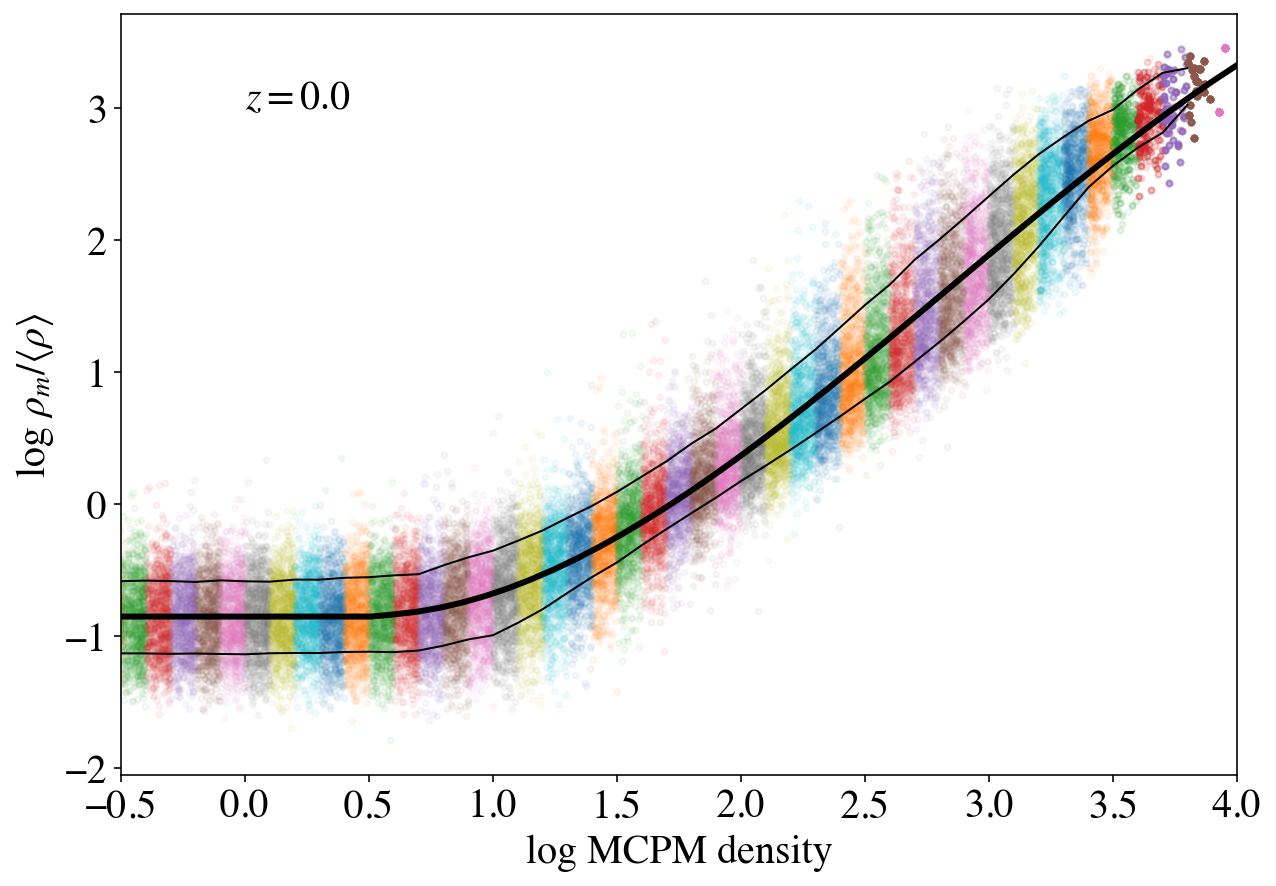

In [67]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Times"
matplotlib.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20

fig = plt.figure(figsize=(10,7))
for i in range(len(smdistribs_sm)):
    plt.plot(smdistribs_sm[i][::20], bpdistribs_sm[i][::20],'.',alpha=0.05, rasterized=True)
# plt.scatter(smrhobins[1:-4], medvals_bp[1:-3], marker='_', color='black', linewidth=3)
# plt.step(smrhobins[1:-4], medvals_bp[1:-3], where='mid', color='black', linewidth=1)
plt.plot(smrhobins[1:-4], loperc_bp[1:-3],color='black',linewidth=1)
plt.plot(smrhobins[1:-4], hiperc_bp[1:-3],color='black',linewidth=1)


pipedatadir = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/"
from pyslime.pipeline import interpolate, catalogs

xfull = np.linspace(-0.5, 4, 50)
plt.plot(xfull, interpolate.relu_p3(xfull, 0.85, -0.85, pfit), lw=3, c='black')

plt.xlabel('log MCPM density')
plt.ylabel(r'log $\rho_m / \langle \rho \rangle$');
plt.text(0, 3, r'$z = 0.0$' )
plt.xlim(-0.5, 4)
# plt.savefig('/Users/mwilde/python/pyslime/pyslime/paper/figures/slime_mapping_z0.png', dpi=300)

In [42]:
packageDict_smBins = {'medvals_bp':medvals_bp,'meanvals_bp':meanvals_bp,
              'loperc_bp':loperc_bp,'hiperc_bp':hiperc_bp,'bpdistribs_sm':bpdistribs_sm,
                      'smdistribs_sm':smdistribs_sm,'smrhobins':smrhobins}

# save the data since its so slow:

In [43]:
pickle.dump(packageDict_smBins,open(out_pickle_file,'wb'))

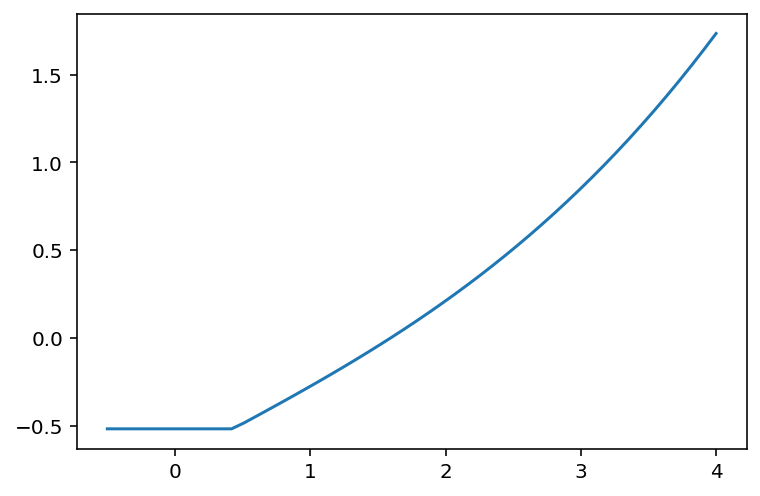